In [1]:
from abc import ABC, abstractmethod

from anytree import AnyNode, RenderTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

## Exercise 1

#### Abstract Base Class
Every subclass of "Expression" must implement these functions

In [2]:
class Expression(ABC):
    
    @abstractmethod
    def __str__(self):
        pass
    
    @abstractmethod
    def eval(self):
        pass
    
    @abstractmethod
    def derivative(self):
        pass
    
    @abstractmethod
    def simplify(self):
        pass

#### Constant Class

In [3]:
class Const(Expression):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return str(self.value)
    
    def eval(self):
        return self.value
    
    def derivative(self, var):
        return Const(0)
    
    def simplify(self):
        return self

#### Variable Class

In [4]:
class Var(Expression):
    def __init__(self, name, value=None):
        self.name = name
        self.value = value
        
    def __str__(self):
        return self.name
    
    def eval(self):
        if self.value is not None:
            return self.value
        else:
            try:
                return env[self.name]
            except:
                raise Exception(f'Variable {self.name} not initialized!')
            
    def derivative(self, var):
        if self.name == var:
            return Const(1)
        else:
            return Const(0)
        
    def simplify(self):
        return self

#### Sum Class

In [5]:
class Sum(Expression):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return f'({str(self.left)}+{str(self.right)})'
    
    def eval(self):
        return self.left.eval() + self.right.eval()
    
    def derivative(self, var):
        return Sum(self.left.derivative(var), self.right.derivative(var))
    
    def simplify(self):
        sx = self.left.simplify()
        sy = self.right.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        try:
            sy_val = sy.eval()
        except:
            sy_val = None
        
        if sx_val == 0:
            return sy
        elif sy_val == 0:
            return sx
        elif isinstance(sx, Const) and isinstance(sy, Const):
            return Const(sx_val + sy_val)
        else:
            return Sum(sx, sy)

#### Subtraction Class

In [6]:
class Sub(Expression):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return f'({str(self.left)}-{str(self.right)})'
    
    def eval(self):
        return self.left.eval() - self.right.eval()
    
    def derivative(self, var):
        return Sub(self.left.derivative(var), self.right.derivative(var))
    
    def simplify(self):
        sx = self.left.simplify()
        sy = self.right.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        try:
            sy_val = sy.eval()
        except:
            sy_val = None
        
        if sy_val == 0:
            return sx
        elif isinstance(sx, Const) and isinstance(sy, Const):
            return Const(sx_val - sy_val)
        elif sx_val == 0:
            return Mul(Const(-1),sy)
        else:
            return Sub(sx, sy)   

#### Multiplication Class

In [7]:
class Mul(Expression):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return f'({str(self.left)}*{str(self.right)})'
    
    def simplify(self):
        if any((self.left.eval() == 0, self.right.eval()==0)):
            return Const(0)
        else:
            return self   
    
    def eval(self):
        return self.left.eval() * self.right.eval()  
    
    def derivative(self, var):
        return Sum(Mul(self.left.derivative(var),self.right),Mul(self.left,self.right.derivative(var)))

    def simplify(self):
        sx = self.left.simplify()
        sy = self.right.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        try:
            sy_val = sy.eval()
        except:
            sy_val = None
            
        if sx_val == 0 or sy_val == 0:
            return Const(0)
        if sx_val == 1:
            return sy
        if sy_val == 1:
            return sx
        elif isinstance(sx, Const) and isinstance(sy, Const):
            return Const(sx_val * sy_val)
        else:
            return Mul(sx, sy)    

#### Division Class

In [8]:
class Div(Expression):
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def __str__(self):
        return f'({str(self.left)}/{str(self.right)})'
    
    def eval(self):
        return self.left.eval() / self.right.eval()
    
    def derivative(self, var):
        dy = self.right.derivative(var)
        return Div(Sub(Mul(self.left.derivative(var),self.right,Mul(self.left,dy),Mul(dy,dy))))
    
    def simplify(self):
        sx = self.left.simplify()
        sy = self.right.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        try:
            sy_val = sy.eval()
        except:
            sy_val = None
            
        if sx_val == 0:
            return Const(0)
        if sy_val == 0:
            raise Exception('division by zero')
        if sy_val == 1:
            return sx
        elif isinstance(sx, Const) and isinstance(sy, Const):
            return Const(sx_val / sy_val)
        else:
            return Div(sx, sy)

#### Exponential Function Class

In [9]:
class Exp(Expression):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        return f'exp({str(self.value)})'
    
    def eval(self):
        return np.exp(self.value.eval())
    
    def derivative(self,var):
        return Mul(Exp(self.value),self.value.derivative(var))

    def simplify(self):
        sx = self.value.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        if sx_val == 0:
            return Const(1)
        elif isinstance(sx, Const):
            return Const(np.exp(sx_val))
        else:
            return Exp(sx)

#### Logarithm Class

In [10]:
class Log(Expression):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        return f'log({str(self.value)})'
    
    def eval(self):
        return np.log(self.value.eval()) 
    
    def derivative(self,var):
        return Div(self.value.derivative(var), self.value)
    
    def simplify(self):
        sx = self.value.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        if sx_val <= 0:
            raise Exception('logarithm of non-positive number')
        elif isinstance(sx, Const):
            return Const(np.log(sx_val))
        else:
            return Log(sx)

#### Hyperbolic Tangent Class

In [11]:
class Tanh(Expression):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        return f'tanh({str(self.value)})'
    
    def eval(self):
        return np.tanh(self.value.eval())   
    
    def derivative(self,var):
        tx = Tanh(self.value)
        return Mul(Sub(Const(1),Mul(tx,tx)),self.value.derivative(var))
    
    def simplify(self):
        sx = self.value.simplify()
        try:
            sx_val = sx.eval()
        except:
            sx_val = None
        if sx_val == 0:
            return Const(0)
        elif isinstance(sx, Const):
            return Const(np.tanh(sx_val))
        else:
            return Tanh(sx)

#### Define a computation graph

In [12]:
x = Var('x')
y = Var('y')

z = Sum(
        Mul(
            Mul(Const(4),x),
            y
        ),
        Exp(
            Mul(Const(-1),y)
        )
    )

#### Print the graph

In [13]:
print(z)

(((4*x)*y)+exp((-1*y)))


#### Visualize as a tree

In [14]:
def build_tree(expr):
    class_name = expr.__class__.__name__
    if isinstance(expr, Const):
        return AnyNode(label=class_name,value=expr.value)
    if  isinstance(expr, Var):
        return AnyNode(label=class_name,value=expr.value,name=expr.name)
    if 'left' in expr.__dir__():
        children = [build_tree(expr.left)]
        children.append(build_tree(expr.right))
    else:
        children = [build_tree(expr.value)]
    return AnyNode(label=class_name, children=children)

In [15]:
z_tree = build_tree(z)

In [16]:
print(RenderTree(z_tree))

AnyNode(label='Sum')
├── AnyNode(label='Mul')
│   ├── AnyNode(label='Mul')
│   │   ├── AnyNode(label='Const', value=4)
│   │   └── AnyNode(label='Var', name='x', value=None)
│   └── AnyNode(label='Var', name='y', value=None)
└── AnyNode(label='Exp')
    └── AnyNode(label='Mul')
        ├── AnyNode(label='Const', value=-1)
        └── AnyNode(label='Var', name='y', value=None)


#### Computing the value of an expression

In [17]:
x = Var('x',2)
y = Var('y',3)
z = Sum(
        Mul(
            Mul(Const(4),x),
            y
        ),
        Exp(
            Mul(Const(-1),y)
        )
    )
z.eval()

24.049787068367863

#### Differentiating an expression

In [18]:
dz_dx = z.derivative('x')
print(dz_dx)

(((((0*x)+(4*1))*y)+((4*x)*0))+(exp((-1*y))*((0*y)+(-1*0))))


#### Simplify the derivative graph

In [19]:
dz_dx_simple = dz_dx.simplify()
print(dz_dx_simple)

(4*y)


In [20]:
print(dz_dx_simple.derivative('y').simplify())

4


### Training a network

#### Forward pass

In [21]:
x1 = Var('x1')
x2 = Var('x2')

b1 = Var('b1')

w11 = Var('w11')
w21 = Var('w21')

b2 = Var('b2')
w12 = Var('w12')
w22 = Var('w22')

z1_out = Tanh(
    Sum(
        b1,
        Sum(
            Mul(x1,w11),
            Mul(x2,w21)
        )
    )
)
z2_out = Tanh(
    Sum(
        b2,
        Sum(
            Mul(x1,w12),
            Mul(x2,w22)
        )
    )
)

c = Var('c')
u1 = Var('u1')
u2 = Var('u2')

f_in = Sum(
            c,
            Sum(
                Mul(z1_out, u1),
                Mul(z2_out, u2)
            )
        )

f_out = Div(
            Const(1),
            Sum(
                Const(1),
                Exp(Mul(Const(-1),f_in))
            )
        )

In [22]:
print(f_out)

(1/(1+exp((-1*(c+((tanh((b1+((x1*w11)+(x2*w21))))*u1)+(tanh((b2+((x1*w12)+(x2*w22))))*u2)))))))


In [23]:
f_out_tree = build_tree(f_out)
print(RenderTree(f_out_tree))

AnyNode(label='Div')
├── AnyNode(label='Const', value=1)
└── AnyNode(label='Sum')
    ├── AnyNode(label='Const', value=1)
    └── AnyNode(label='Exp')
        └── AnyNode(label='Mul')
            ├── AnyNode(label='Const', value=-1)
            └── AnyNode(label='Sum')
                ├── AnyNode(label='Var', name='c', value=None)
                └── AnyNode(label='Sum')
                    ├── AnyNode(label='Mul')
                    │   ├── AnyNode(label='Tanh')
                    │   │   └── AnyNode(label='Sum')
                    │   │       ├── AnyNode(label='Var', name='b1', value=None)
                    │   │       └── AnyNode(label='Sum')
                    │   │           ├── AnyNode(label='Mul')
                    │   │           │   ├── AnyNode(label='Var', name='x1', value=None)
                    │   │           │   └── AnyNode(label='Var', name='w11', value=None)
                    │   │           └── AnyNode(label='Mul')
                    │   │               ├─

In [24]:
# set variable values through environment:
env = {
    'b1': 1.543385, 
    'w11': 3.111573, 
    'w12': -2.808800,
    'b2': 1.373085, 
    'w21': 3.130452, 
    'w22': -2.813466,
    'c': -4.241453, 
    'u1': 4.036489, 
    'u2': 4.074885,
    'x1': 1,
    'x2': -1
}

In [25]:
z1_out.eval()

0.9094797051327462

#### Loss

In [26]:
y = Var('y')

loss = Sum(
    Sub(
        f_in,
        Mul(f_in,y)
    ),
    Log(Sum(
        Const(1),
        Exp(Mul(Const(-1),f_in))
    ))
)

In [27]:
print(loss)

(((c+((tanh((b1+((x1*w11)+(x2*w21))))*u1)+(tanh((b2+((x1*w12)+(x2*w22))))*u2)))-((c+((tanh((b1+((x1*w11)+(x2*w21))))*u1)+(tanh((b2+((x1*w12)+(x2*w22))))*u2)))*y))+log((1+exp((-1*(c+((tanh((b1+((x1*w11)+(x2*w21))))*u1)+(tanh((b2+((x1*w12)+(x2*w22))))*u2))))))))


#### Gradients

In [28]:
# Note: when variable values can be updated from "outside" (i.e., through the env dict)
# simplification should not be used in the way it is implemented here (a simplification could only be valid
# for a given value of the variable, and changing this value after the fact could thus make the simplification invalid)
param_names = ("b1", "w11", "w12", "b2", "w21", "w22", "c", "u1", "u2")
gradient_graphs = list(map(lambda x: loss.derivative(x).simplify(), param_names))

In [29]:
print(gradient_graphs[1])

((((1-(tanh((b1+(w11+(x2*w21))))*tanh((b1+(w11+(x2*w21))))))*u1)-(((1-(tanh((b1+(w11+(x2*w21))))*tanh((b1+(w11+(x2*w21))))))*u1)*y))+((exp((-1*(c+((tanh((b1+(w11+(x2*w21))))*u1)+(tanh((b2+(w12+(x2*w22))))*u2)))))*(-1*((1-(tanh((b1+(w11+(x2*w21))))*tanh((b1+(w11+(x2*w21))))))*u1)))/(1+exp((-1*(c+((tanh((b1+(w11+(x2*w21))))*u1)+(tanh((b2+(w12+(x2*w22))))*u2))))))))


#### Training data

In [30]:
train_data = pd.DataFrame(data=np.array([[0,1,0,-1,0],[0,0,-1,0,1],[1,0,0,0,0]]).T, columns=['x1','x2','y'] )
train_data

,x1,x2,y
0,0,0,1
1,1,0,0
2,0,-1,0
3,-1,0,0
4,0,1,0


#### Initialization

In [31]:
def glorot_initialization():
    b = np.sqrt(6/4)
    return np.random.uniform(-b, b,1)[0]

In [32]:
for p in param_names:
    if 'b' in p or 'c' in p:
        env[p]= 0
    else:
        env[p] = glorot_initialization()

In [33]:
env

{'b1': 0,
 'w11': -0.20325374835775567,
 'w12': 0.5396825867704658,
 'b2': 0,
 'w21': -1.2244647114496698,
 'w22': -0.48418433582064735,
 'c': 0,
 'u1': -0.8652678221420625,
 'u2': -0.9985624306424064,
 'x1': 1,
 'x2': -1}

#### Training loop

In [34]:
losses = []
epoch_losses = []
for e in range(250):
    epoch_loss = 0
    epoch_parameters_grads = np.zeros(len(param_names))
    for j in range(5):
        env['x1'] = train_data.x1[j]
        env['x2'] = train_data.x2[j] 
        env['y'] = train_data.y[j]
        
        this_loss = loss.eval()
        epoch_loss += this_loss
        losses.append(this_loss)
        gradients = list(map(lambda x: loss.derivative(x).eval(), param_names))
        
        # alternative 1 - stochastic gradient descent
#         for p, grad in zip(param_names, gradients):
#             env[p] = env[p] - 0.5 * grad
        # end alternative 1
        
        # alternative 2 - gradient descent
        for i, grad in enumerate(gradients):
            epoch_parameters_grads[i] = epoch_parameters_grads[i] + grad/5
            
    for i, p in enumerate(param_names):
        env[p] = env[p] - 2.5 * epoch_parameters_grads[i]
        # end alternative 2
            
    epoch_losses.append(epoch_loss)

#### Visualization

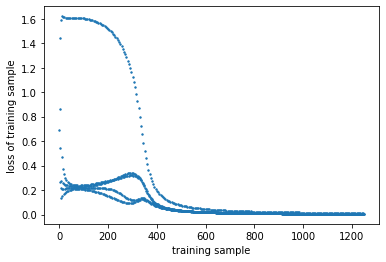

In [35]:
plt.figure()
plt.scatter(range(len(losses)),losses, s=2)
plt.ylabel('loss of training sample')
plt.xlabel('training sample')
plt.show()

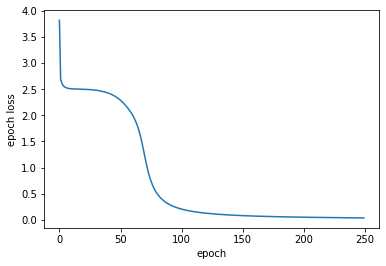

In [36]:
plt.figure()
plt.plot(epoch_losses)
plt.ylabel('epoch loss')
plt.xlabel('epoch')
plt.show()

#### Predictions

In [37]:
for j in range(5):
    env['x1'] = train_data.x1[j]
    env['x2'] = train_data.x2[j] 
    env['y'] = train_data.y[j]
    
    pred = f_out.eval()
    print(f'Sample {j}, label {env["y"]}, pred {pred}')

Sample 0, label 1, pred 0.9879618221372729
Sample 1, label 0, pred 0.005694968975560848
Sample 2, label 0, pred 0.00560798240846052
Sample 3, label 0, pred 0.005624236673691374
Sample 4, label 0, pred 0.00569446455420342
